### Training the Autoencoder

In [1]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda as cuda
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict

import matplotlib.pyplot as plt
import pickle as pkl

dtype = torch.FloatTensor
# Cuda active?
if cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print("GPU: {}".format(cuda.get_device_name(0)))
    cuda_available = True
else:
    cuda_available = False
    print("Cuda unavailable.")

GPU: GeForce GTX 1080 Ti


In [2]:
#%%writefile hyperspectral_dataset.py
# Load data
import torch
from torch.utils.data import Dataset
import csv, numpy as np
import os
import OpenEXR as exr, Imath
from collections import defaultdict
from PIL import Image
from skimage.transform import resize
####################
# Helper functions #
####################

def readEXRImage(filepath, channelrange):
    """Helper function for reading .exr files from the KAIST dataset.
    Returns an array with dimension ordering (C, H, W) as required by pytorch.
    """
    file = exr.InputFile(filepath)
    channels = ["w{}nm".format(wavelength) for wavelength in channelrange]
    header = file.header()
    ncols = header["displayWindow"].max.x+1
    nrows = header["displayWindow"].max.y+1
    pt = Imath.PixelType(Imath.PixelType.HALF)
    imgstrs = file.channels(channels, pt)
    full = np.zeros((len(channels), nrows, ncols), dtype=np.float16)
    for i, imgstr in enumerate(imgstrs):
        red = np.frombuffer(imgstr, dtype=np.float16)
        full[i,:,:] = np.reshape(red, (nrows, ncols))
    return full

def readPNGImage(filedir, filename, channelrange, minwavelength, increment):
    """Helper function for reading patches from the set of png files from the CAVE dataset.
    """
    indexes = [int((wavelength-minwavelength)/increment + 1) for wavelength in channelrange]
    # Get image size:
    img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, 1)))
    full = np.zeros((len(channelrange),) + img.size, dtype=np.float16)
    img.close()
    for i, index in enumerate(indexes):
        img = Image.open(os.path.join(filedir, "{}_{:02}.png".format(filename, index)))
        # Divide by max val of np.uint16 to normalize image
        full[i,:,:] = np.array(img, dtype=np.float32)/np.iinfo(np.uint16).max
    return full

###########
# Dataset #
###########
# For reference, the csv field names: 
# fieldnames = ["type", "dir", "name", "row", "col", "side", "scale", "flip"]

class HyperspectralDataset(Dataset):
    def __init__(self, csvfile, minwavelength, maxwavelength, nchannels, height, width):
        """Open and load the lines of the csvfile."""
        self.minwavelength = minwavelength
        self.maxwavelength = maxwavelength
        self.channelrange = range(self.minwavelength, self.maxwavelength+1, 10)
        
        
        # Store dictionaries mapping the image name to
        # - a list of entries that stem from that image
        # - the datatype (exr or png) of the image
        # - the filepath to that image
        self.update_entries(csvfile)

    def update_entries(self, csvfile):
        """Refresh the dataset without reloading the images, but adding a different set of csv files."""
        self.dataEntries = []
        self.namesToImages = {}
        with open(csvfile, "r") as f:
            reader = csv.DictReader(f)
            for entry in reader:
                self.dataEntries.append(entry)
                # Add the full image to the dict if not already included.
                if entry["name"] not in self.namesToImages:
                    print("loading {}".format(entry["name"]))
                    # Need to read the image into the dictionary
                    if entry["type"] == "exr":
                        filepath = os.path.join(entry["dir"], entry["name"])
                        self.namesToImages[entry["name"]] = readEXRImage(filepath, self.channelrange)
                    elif entry["type"] == "png":
                        self.namesToImages[entry["name"]] = readPNGImage(entry["dir"], entry["name"],
                                                                           self.channelrange,
                                                                           self.minwavelength,
                                                                           self.maxwavelength)
                    else:
                        raise ValueError("Invalid entry at row {} - Cannot load data of type '{}'.".format(idx, dtype))
                    print("\tSize: {} bytes.".format(self.namesToImages[entry["name"]].nbytes))
                    
    def __len__(self):
        return len(self.dataEntries)
    
    def __getitem__(self, idx):
        entry = self.dataEntries[idx]
        image = self.namesToImages[entry["name"]]
        side = int(entry["side"])
        scale = float(entry["scale"])
        i = int(entry["row"])
        j = int(entry["col"])
        shape = (int(side/scale),
                 int(side/scale)
                )
        patch = image[:, i:i+shape[0], j:j+shape[0]]
        # Resizing
        patch = resize(patch, (patch.shape[0], side, side), mode="constant")
        # Flip if necessary:
        if entry["flip"]:
            patch = np.flip(patch, axis=3) # Horizontal flip

        # Convert to Torch tensor and return
        out = torch.Tensor(patch.copy()).type(dtype).cpu()
        return out




In [3]:
# %%writefile build_autoencoder.py
import torch
import torch.nn as nn
import torch.cuda as cuda
from collections import OrderedDict

def build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers):
    samepad = int((filtersize-1)/2)

    ###########
    # Encoder #
    ###########
    encoderLayers = [nn.Conv2d(inchannels, outchannels, filtersize, padding=samepad)]
    for i in range(nlayers-1):
        encoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, outchannels, filtersize, padding=samepad)]
    Encoder = nn.Sequential(*encoderLayers)

    ###########
    # Decoder #
    ########### 
    decoderLayers = [] 
    for i in range(nlayers-1):
        decoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, outchannels, filtersize, padding=samepad)]
    decoderLayers += [nn.ReLU(), nn.Conv2d(outchannels, inchannels, filtersize, padding=samepad), nn.ReLU()]
    Decoder = nn.Sequential(*decoderLayers)

    ###############
    # Autoencoder #
    ###############
    Autoencoder = nn.Sequential(OrderedDict([
        ("Encoder", Encoder),
        ("Decoder", Decoder)])
    )
    return Autoencoder




In [4]:
# %%writefile utils.py
import torch
from torch.utils.data import Dataset, DataLoader
import torch.cuda as cuda
import matplotlib.pyplot as plt
# Helper functions

#################
# Checkpointing #
#################
def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar', always_save=False):
    """Save checkpoint if a new best is achieved"""
    if is_best or always_save:
        print ("=> Saving checkpoint to: {}".format(filename))
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

####################
# Loss Computation #
####################
def compute_loss(loss, output, data, lam, model):
    out = 0.5*loss(output, data)
    # Extract layer weights for regularization
    for name, param in model.named_parameters():
        if "weight" in name:
            out += lam*(param.norm()**2)
    return out

##############
# Validation #
##############
def validate(loss, model, val_data, lam, weights, cuda_available):
    """Computes the validation error of the model on the validation set.
    val_data should be a Dataset where the first batch loads all of the data."""
    val_loader = DataLoader(val_data, batch_size=4, shuffle=True)
    _, val_tensor = next(enumerate(val_loader))
    if cuda.is_available():
        val_tensor.cuda()
    val_set = Variable(val_tensor, requires_grad = False)
    output = model(val_set)
    return compute_loss(loss, output, val_set, lam, weights)

############
# Plotting #
############
def save_train_val_loss_plots(trainlosses, vallosses, epoch):
    # Train loss
    fig = plt.figure()
    plt.plot(trainlosses)
    plt.title("Train loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig("trainloss_epoch{}.png".format(epoch))
    # Train loss
    fig = plt.figure()
    plt.plot(trainlosses)
    plt.title("Val loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.savefig("Val loss{}.png".format(epoch))




In [6]:
# Set up training.
checkpointfile = None
lam = 1e-8 # Weight decay parameter for L2 regularization
learning_rate = 1e-5
num_epochs = 60
batch_size = 64

# Build model and loss
# Hyperparameters
height = 96
width = 96
inchannels = 29
outchannels = 64
filtersize = 3
nlayers = 11
samepad = int((filtersize-1)/2)

Autoencoder = build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers)
loss = nn.MSELoss()

if cuda.is_available():
    Autoencoder.cuda()
    loss.cuda()

# Checkpointing
if checkpointfile is not None:
    if cuda_available:
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    Autoencoder.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(Autoencoder.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    trainlosses = checkpoint['trainlosses']
#     vallosses = checkpoint['vallosses']
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
else:
    start_epoch = 0
    best_loss = torch.FloatTensor([float('inf')])
    optimizer = optim.Adam(Autoencoder.parameters(), lr=learning_rate)
    trainlosses = []
    vallosses = []
    # Initialize weights:
    for name, param in Autoencoder.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform(param)
        elif "bias" in name:
            nn.init.constant(param, 0)
            
# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)
scheduler.last_epoch = start_epoch - 1

# Print summary of setup:
print("checkpointfile: {}".format(checkpointfile))
print("start_epoch: {}".format(start_epoch))
print("optimizer: {}".format(optimizer))
print("batch_size: {}".format(batch_size))
print("num_epochs: {}".format(num_epochs))
print("learning rate (initial): {}".format(learning_rate))

checkpointfile: None
start_epoch: 0
optimizer: <torch.optim.adam.Adam object at 0x7f7852e26a90>
batch_size: 64
num_epochs: 60
learning rate (initial): 1e-05


In [20]:
######################
# Load Training Data #
######################
# Note: only need to do once.
rebuild_dataset = True
train_data_csv = "data/train_large.csv"
if rebuild_dataset:
    train_data = HyperspectralDataset(train_data_csv, 420, 700, inchannels, height, width)
else:
    train_data.update_entries(train_data_csv)

print("Images in training data set: {}". format(len(train_data)))

loading scene14_reflectance.exr
	Size: 529464832 bytes.
loading scene23_reflectance.exr
	Size: 529464832 bytes.
loading real_and_fake_apples_ms
	Size: 15204352 bytes.
loading scene26_reflectance.exr
	Size: 529464832 bytes.
loading scene21_reflectance.exr
	Size: 529464832 bytes.
loading scene18_reflectance.exr
	Size: 529464832 bytes.
loading fake_and_real_lemons_ms
	Size: 15204352 bytes.
loading scene30_reflectance.exr
	Size: 529464832 bytes.
loading fake_and_real_beers_ms
	Size: 15204352 bytes.
loading superballs_ms
	Size: 15204352 bytes.
loading scene09_reflectance.exr
	Size: 529464832 bytes.
loading scene24_reflectance.exr
	Size: 529464832 bytes.
loading scene15_reflectance.exr
	Size: 529464832 bytes.
loading scene27_reflectance.exr
	Size: 529464832 bytes.
loading thread_spools_ms
	Size: 15204352 bytes.
loading fake_and_real_food_ms
	Size: 15204352 bytes.
loading scene29_reflectance.exr
	Size: 529464832 bytes.
loading chart_and_stuffed_toy_ms
	Size: 15204352 bytes.
loading fake_and_r

In [ ]:
####################
# Run the training #
####################
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

for epoch in range(start_epoch, num_epochs):
    print("epoch: {}".format(epoch))
    scheduler.step()
    for it, input_ in enumerate(train_loader):
        input_ = Variable(input_, requires_grad=False)
        if cuda_available:
            input_ = input_.cuda()
        # New batch
        scheduler.optimizer.zero_grad()
        output = Autoencoder(input_)
        trainloss = compute_loss(loss, output, input_, lam, Autoencoder)
        trainloss.backward()
        scheduler.optimizer.step()
        if not (it % 10):
            print("\titeration: {}\ttrain loss: {}".format(it, trainloss.data[0]))
        trainlosses.append(trainloss.data[0])
    # Checkpointing
    # Get bool not ByteTensor
#     valloss = validate(loss, Autoencoder, val_data, lam, weights, cuda_available)
#     print("End epoch {}\tval loss: {}".format(epoch, valloss.data[0]))
#     vallosses.append(valloss.data[0])

    is_best = bool(trainloss.data.cpu().numpy() < best_loss.numpy())
    # Get greater Tensor to keep track best acc
    best_loss = torch.FloatTensor(min(trainloss.data.cpu().numpy(), best_loss.numpy()))
    # Save checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': Autoencoder.state_dict(),
        'best_loss': best_loss,
        'optim_state_dict': optimizer.state_dict(),
        'trainlosses': trainlosses
#         'vallosses': vallosses
    }, is_best, filename="checkpoints/checkpoint_epoch_{}.pth.tar".format(epoch), always_save=True)
    

epoch: 0
	iteration: 0	train loss: 0.00654228962957859
	iteration: 10	train loss: 0.006763617508113384
	iteration: 20	train loss: 0.00852988287806511
	iteration: 30	train loss: 0.00872713141143322
	iteration: 40	train loss: 0.00595971941947937
	iteration: 50	train loss: 0.012237140908837318
	iteration: 60	train loss: 0.008441410958766937
	iteration: 70	train loss: 0.009560192935168743
	iteration: 80	train loss: 0.006406854838132858
	iteration: 90	train loss: 0.0045232404954731464
	iteration: 100	train loss: 0.0030915180686861277
	iteration: 110	train loss: 0.004827448166906834
	iteration: 120	train loss: 0.0013804048066958785
	iteration: 130	train loss: 0.001844298210926354
	iteration: 140	train loss: 0.0018614917062222958
	iteration: 150	train loss: 0.001998655265197158
	iteration: 160	train loss: 0.0030847324524074793
	iteration: 170	train loss: 0.0021100991871207952
	iteration: 180	train loss: 0.005381548311561346
	iteration: 190	train loss: 0.0030192898120731115
	iteration: 200	tra

### Validating the autoencoder

In [7]:
# Load val image(s)
# val_data_csv ="data/kaist_set/kaist_val_very_small.csv"
val_data_csv = "data/kaist_set/kaist_val_very_small.csv"
val_data = HyperspectralDataset(val_data_csv, 420, 700, inchannels, height, width)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, pin_memory=True)

loading scene26_reflectance.exr
	Size: 529464832 bytes.
loading scene17_reflectance.exr
	Size: 529464832 bytes.
loading scene22_reflectance.exr
	Size: 529464832 bytes.


In [8]:
# Get validation losses
# checkpointfile = "overfit_checkpoints/checkpoint_epoch_499.pth.tar"
num_epochs = 60
lam = 1e-8 # Weight decay parameter for L2 regularization
_, input_ = next(enumerate(val_loader))
if cuda_available:
    input_ = input_.cuda()
####################
# Make Autoencoder #
####################
# Hyperparameters
height = 96
width = 96
inchannels = 29
outchannels = 64
filtersize = 3
nlayers = 11
samepad = int((filtersize-1)/2)
Autoencoder = build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers)
if cuda.is_available():
    Autoencoder.cuda()
# Set to inference mode
for param in Autoencoder[0].parameters():
    param.requires_grad = False
for param in Autoencoder[1].parameters():
    param.requires_grad = False
    
input_ = Variable(input_, requires_grad=False)
vallosses = []
# Autoencoder = build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers)
for epoch in range(num_epochs):
#     Autoencoder = None
#     torch.cuda.empty_cache()
    checkpointfile = "checkpoints/checkpoint_epoch_{}.pth.tar".format(epoch)
#     if cuda_available:
    if cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
#     Autoencoder = build_autoencoder(height, width, inchannels, outchannels, filtersize, nlayers).cuda()


    Autoencoder.load_state_dict(checkpoint['state_dict'])
    trainlosses = checkpoint["trainlosses"]
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(checkpointfile, checkpoint['epoch']))



    output = Autoencoder(input_)
    valloss = compute_loss(loss, output, input_, lam, Autoencoder)
#     del output
#     del Autoencoder
#     torch.cuda.empty_cache()
    vallosses.append(valloss.data[0])



=> loaded checkpoint 'checkpoints/checkpoint_epoch_0.pth.tar' (trained for 1 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_1.pth.tar' (trained for 2 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_2.pth.tar' (trained for 3 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_3.pth.tar' (trained for 4 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_4.pth.tar' (trained for 5 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_5.pth.tar' (trained for 6 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_6.pth.tar' (trained for 7 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_7.pth.tar' (trained for 8 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_8.pth.tar' (trained for 9 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_9.pth.tar' (trained for 10 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_10.pth.tar' (trained for 11 epochs)
=> loaded checkpoint 'checkpoints/checkpoint_epoch_11.pth.tar'

Text(0,0.5,'Loss')

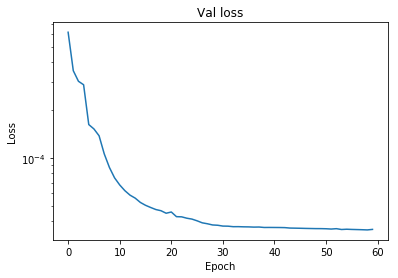

In [9]:
# Val loss
fig = plt.figure()
plt.semilogy(vallosses)
plt.title("Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.savefig("trainloss_epoch{}.png".format(epoch))

Text(0,0.5,'Loss')

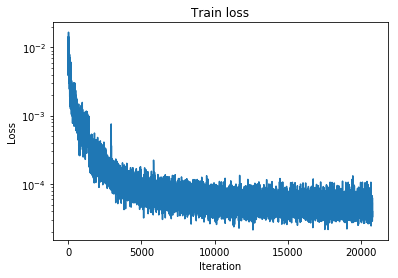

In [10]:
# Train loss
fig = plt.figure()
plt.semilogy(trainlosses)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
# plt.savefig("trainloss_epoch{}.png".format(epoch))